In [1]:
import os
import copy
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mlp
import seaborn as sns
%matplotlib inline
from transformers import AutoTokenizer, AutoModelWithLMHead
import shap
from shap.utils import GenerateLogits
import scipy as sp
import nlp
import torch
import spacy
from shap.utils import assert_import, record_import_error, safe_isinstance, make_masks, OpChain, MaskedModel
from shap import maskers, links

"is not" with a literal. Did you mean "!="?


In [64]:
dataset = nlp.load_dataset('xsum',split='train')

WARNING - Using custom data configuration default


In [17]:

model =  AutoModelWithLMHead.from_pretrained("sshleifer/distilbart-xsum-12-6")

The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.


In [2]:
tokenizer1 = AutoTokenizer.from_pretrained("sshleifer/distilbart-xsum-12-6")
tokenizer2 = AutoTokenizer.from_pretrained("Helsinki-NLP/opus-mt-en-es")
tokenizer3 = AutoTokenizer.from_pretrained("distilgpt2")

In [18]:
# Instantiate object of GenerateLogits with model and tokenizer
logit_generator_model = GenerateLogits(model=model,tokenizer=tokenizer1,device='cpu')

In [19]:
def f_predict(x):
    model.eval()
    input_ids = torch.tensor([tokenizer.encode(x)])
    with torch.no_grad():
        out=model.generate(input_ids)
    sentence = [tokenizer.decode(g, skip_special_tokens=True) for g in out][0]
    del input_ids, out
    return sentence

In [20]:
def gen_kwargs(x):
    model.eval()
    input_ids = torch.tensor([tokenizer.encode(x)])
    with torch.no_grad():
        # generate input ids for output translation which we aim to explain
        out=model.generate(input_ids)
    # slice sentence by removing bos and eos token ids
    target_sentence_ids = out[:,1:-1]
    output_names = logit_generator_model.get_output_names(target_sentence_ids)
    del out
    return {'target_sentence_ids':target_sentence_ids,'input_ids':input_ids,'output_names':output_names,'fixed_context':0}

In [21]:
# This function defines the additional arguments passed onto the model function required inorder to get conditional logits corresponding to the original input sentence translation
def f_kwargs(x):
    kwargs = gen_kwargs(x)
    return kwargs

In [22]:
def f(x_batch,**kwargs):
    output_batch=[]
    # Extract target sentence for which we want to generate conditional logits
    target_sentence_ids=kwargs['target_sentence_ids']
    for i,source_sentence in enumerate(x_batch):
        conditional_logits = logit_generator_model.generate_logits(source_sentence,target_sentence_ids)
        output_batch.append(conditional_logits)
    return np.array(output_batch)

In [23]:
explainer = shap.Explainer(f,tokenizer1)
explainer.masker.mask_token_id=None
explainer.masker.mask_token=""

explainers.Partition is still in an alpha state, so use with caution...


In [24]:
explainer.masker.tokenizer

In [12]:
row_args=(dataset['document'][0],)
#fm = MaskedModel(explainer.model, explainer.masker, explainer.link,*row_args,model_kwargs=f_kwargs)
explainer._clustering = explainer.masker.clustering(*row_args)

In [13]:
feature_names = [explainer.masker.tokenizer.decode([v]) for v in explainer.masker._tokenized_s]

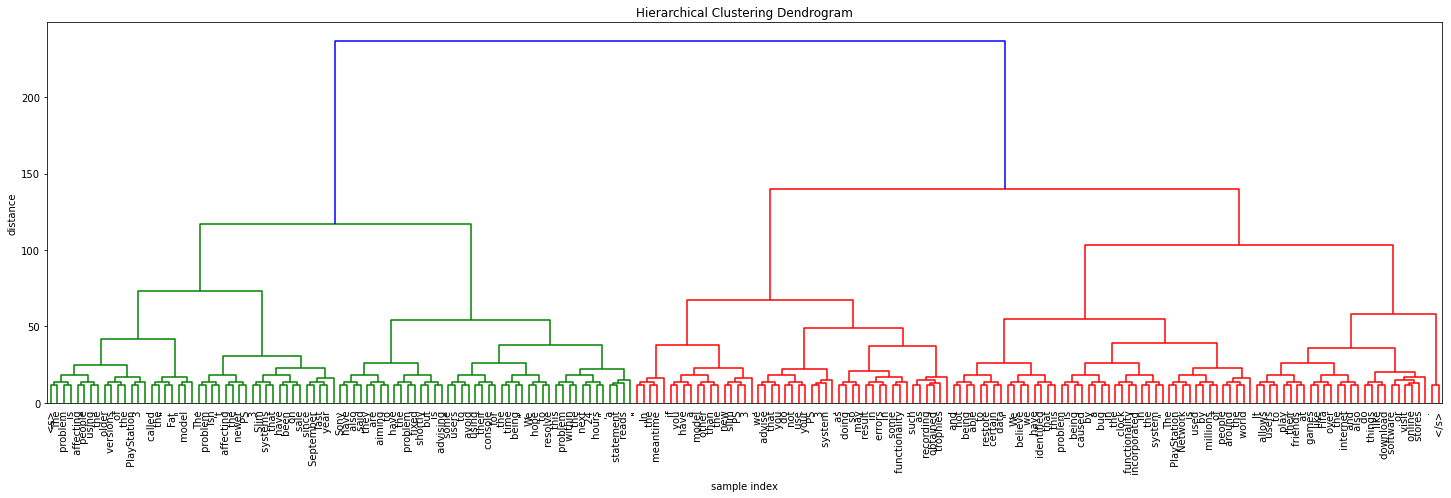

In [14]:

# plot the clustering
mlp.rcParams['figure.figsize']=(25,7)
#plt.figure(figsize=(25, 7))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
sp.cluster.hierarchy.dendrogram(
    explainer._clustering,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=10.,  # font size for the x axis labels
    labels=feature_names,
)
plt.show()

In [15]:
dataset['document'][0]

'The problem is affecting people using the older versions of the PlayStation 3, called the "Fat" model.The problem isn\'t affecting the newer PS3 Slim systems that have been on sale since September last year.Sony have also said they are aiming to have the problem fixed shortly but is advising some users to avoid using their console for the time being."We hope to resolve this problem within the next 24 hours," a statement reads. "In the meantime, if you have a model other than the new slim PS3, we advise that you do not use your PS3 system, as doing so may result in errors in some functionality, such as recording obtained trophies, and not being able to restore certain data."We believe we have identified that this problem is being caused by a bug in the clock functionality incorporated in the system."The PlayStation Network is used by millions of people around the world.It allows users to play their friends at games like Fifa over the internet and also do things like download software o

In [15]:
s="Roger Lewis saw the stars, with the telescope. Anne Lewis too saw the stars with the telescope. Fantabulous!"

In [26]:
explainer = shap.Explainer(f,tokenizer1)
explainer.masker.mask_token_id=None
explainer.masker.mask_token=""
row_args=(s,)
#fm = MaskedModel(explainer.model, explainer.masker, explainer.link,*row_args,model_kwargs=f_kwargs)
explainer._clustering = explainer.masker.clustering(s)
feature_names = [explainer.masker.tokenizer.decode([v]) for v in explainer.masker._tokenized_s]

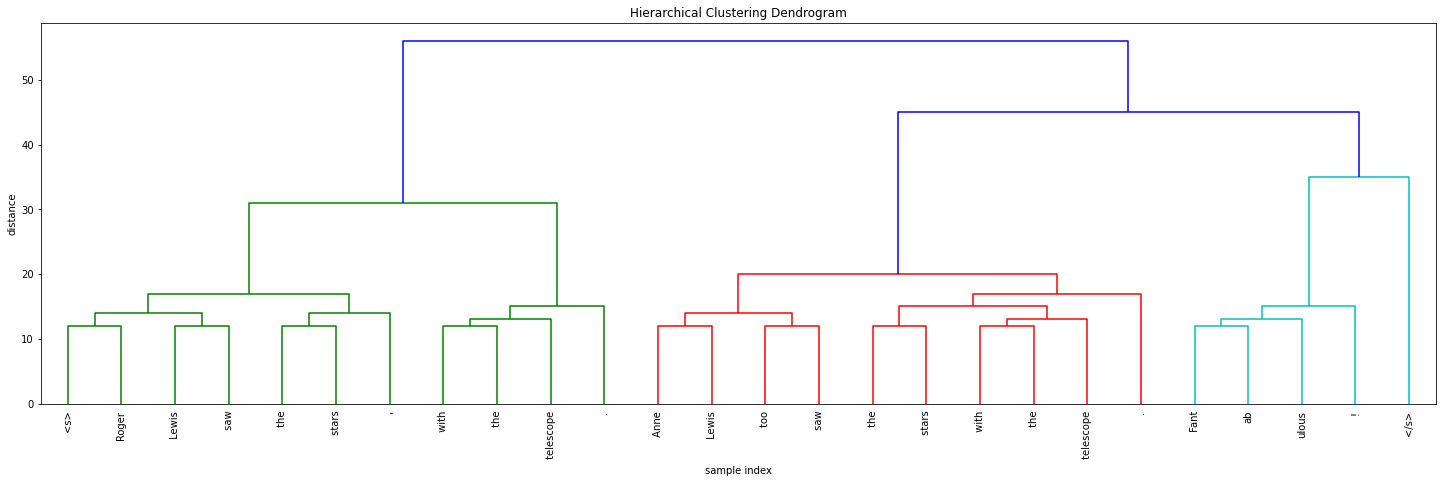

In [27]:
# plot the clustering
mlp.rcParams['figure.figsize']=(25,7)
#plt.figure(figsize=(25, 7))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
sp.cluster.hierarchy.dendrogram(
    explainer._clustering,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=10.,  # font size for the x axis labels
    labels=feature_names,
)
plt.show()

In [3]:
import spacy
from spacy import displacy
from benepar.spacy_plugin import BeneparComponent
import benepar

In [4]:
nlp = spacy.load("en_core_web_sm")

In [5]:
s="Roger Lewis saw the stars, with the telescope. Anne Lewis too saw the stars with the telescope. Fantabulous!"

In [7]:
print(tokenizer1.convert_ids_to_tokens(tokenizer1.encode(s)))

['<s>', 'Roger', 'ĠLewis', 'Ġsaw', 'Ġthe', 'Ġstars', ',', 'Ġwith', 'Ġthe', 'Ġtelescope', '.', 'ĠAnne', 'ĠLewis', 'Ġtoo', 'Ġsaw', 'Ġthe', 'Ġstars', 'Ġwith', 'Ġthe', 'Ġtelescope', '.', 'ĠFant', 'ab', 'ulous', '!', '</s>']


In [8]:
print(tokenizer2.convert_ids_to_tokens(tokenizer2.encode(s)))

['▁Roger', '▁Lewis', '▁saw', '▁the', '▁stars', ',', '▁with', '▁the', '▁telescope', '.', '▁Anne', '▁Lewis', '▁too', '▁saw', '▁the', '▁stars', '▁with', '▁the', '▁telescope', '.', '▁F', 'anta', 'b', 'ulous', '!', '</s>']


In [9]:
print(tokenizer3.convert_ids_to_tokens(tokenizer3.encode(s)))

['Roger', 'ĠLewis', 'Ġsaw', 'Ġthe', 'Ġstars', ',', 'Ġwith', 'Ġthe', 'Ġtelescope', '.', 'ĠAnne', 'ĠLewis', 'Ġtoo', 'Ġsaw', 'Ġthe', 'Ġstars', 'Ġwith', 'Ġthe', 'Ġtelescope', '.', 'ĠFant', 'ab', 'ulous', '!']


In [34]:
for token in doc:
    print(f'\'{token.text}\'',end=", ")

'Roger', 'Lewis', 'saw', 'the', 'stars', ',', 'with', 'the', 'telescope', '.', 'Anne', 'Lewis', 'too', 'saw', 'the', 'stars', 'with', 'the', 'telescope', '.', 'Fantabulous', '!', 

In [11]:
doc = nlp(s)

In [28]:
options = {"compact": True, "color": "blue","collapse_phrases":False}

In [29]:
displacy.serve(doc, style="dep", options=options)


Using the 'dep' visualizer
Serving on http://0.0.0.0:5000 ...

Shutting down server on port 5000.


In [38]:
displacy.serve(doc, style="dep", options=options)


Using the 'dep' visualizer
Serving on http://0.0.0.0:5000 ...

Shutting down server on port 5000.


In [14]:
displacy.serve(doc, style="ent")


Using the 'ent' visualizer
Serving on http://0.0.0.0:5000 ...

Shutting down server on port 5000.


In [35]:
matrix = list(doc.sents)[0].get_lca_matrix()

In [36]:
len(list(doc.sents))

3

In [38]:
for i in range(len(list(doc.sents))):
    matrix = list(doc.sents)[i].get_lca_matrix()
    print()
    print(matrix)


[[0 1 2 2 2 2 2 2 2 2]
 [1 1 2 2 2 2 2 2 2 2]
 [2 2 2 2 2 2 2 2 2 2]
 [2 2 2 3 4 2 2 2 2 2]
 [2 2 2 4 4 2 2 2 2 2]
 [2 2 2 2 2 5 2 2 2 2]
 [2 2 2 2 2 2 6 6 6 2]
 [2 2 2 2 2 2 6 7 8 2]
 [2 2 2 2 2 2 6 8 8 2]
 [2 2 2 2 2 2 2 2 2 9]]

[[0 1 3 3 3 3 3 3 3 3]
 [1 1 3 3 3 3 3 3 3 3]
 [3 3 2 3 3 3 3 3 3 3]
 [3 3 3 3 3 3 3 3 3 3]
 [3 3 3 3 4 5 3 3 3 3]
 [3 3 3 3 5 5 3 3 3 3]
 [3 3 3 3 3 3 6 6 6 3]
 [3 3 3 3 3 3 6 7 8 3]
 [3 3 3 3 3 3 6 8 8 3]
 [3 3 3 3 3 3 3 3 3 9]]

[[0 0]
 [0 1]]


In [59]:
matrix

array([[0, 1, 2, 2, 2, 2, 2, 2, 2],
       [1, 1, 2, 2, 2, 2, 2, 2, 2],
       [2, 2, 2, 2, 2, 2, 2, 2, 2],
       [2, 2, 2, 3, 4, 2, 2, 2, 2],
       [2, 2, 2, 4, 4, 2, 2, 2, 2],
       [2, 2, 2, 2, 2, 5, 5, 5, 2],
       [2, 2, 2, 2, 2, 5, 6, 7, 2],
       [2, 2, 2, 2, 2, 5, 7, 7, 2],
       [2, 2, 2, 2, 2, 2, 2, 2, 8]])

In [39]:
doc

Roger Lewis saw the stars with the telescope. Anne Lewis too saw the stars with the telescope.

In [41]:
list(doc.sents)

[Roger Lewis saw the stars with the telescope.,
 Anne Lewis too saw the stars with the telescope.]

In [42]:
doc.sents